<a href="https://colab.research.google.com/github/Madaraka02/IMDB_bert_sentiment_polarity/blob/main/BERTSentimentPolarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf

In [ ]:
#load data from link
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

data = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

data_dir = os.path.join(os.path.dirname(data), 'aclImdb')
os.listdir(data_dir)

train_data = os.path.join(data_dir, 'train')
os.listdir(train_data)

['neg',
 'unsup',
 'urls_pos.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'pos']

In [ ]:
import shutil
remove_dir = os.path.join(train_data, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [ ]:
#create tf data for training validation and testing
train_dataset = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = train_dataset.class_names
train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
!# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 26.2 MB/s 
     |████████████████████████████████| 462 kB 62.6 MB/s 


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 27.9 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 92 kB 12.4 MB/s 
     |████████████████████████████████| 1.1 MB 66.6 MB/s 
     |████████████████████████████████| 596 kB 71.4 MB/s 
     |████████████████████████████████| 99 kB 12.2 MB/s 
     |████████████████████████████████| 352 kB 59.9 MB/s 
     |████████████████████████████████| 1.2 MB 63.4 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
     |████████████████████████████████| 237 kB 65.6 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

In [ ]:
#Load bert model from tensorflow hub

In [ ]:
bert_model_name         = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


In [ ]:
#Create model with BERT layers to read text and encode them 

In [ ]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  lastlayer = outputs['pooled_output']
  lastlayer = tf.keras.layers.Dropout(0.1)(lastlayer)
  lastlayer = tf.keras.layers.Dense(1, activation=None, name='classifier')(lastlayer)
  return tf.keras.Model(text_input, lastlayer)

In [ ]:
model = build_model()

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics =['accuracy']

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:

history = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 379s 598ms/step - loss: 0.6642 - binary_accuracy: 0.5793 - val_loss: 0.5703 - val_binary_accuracy: 0.6514
Epoch 2/5
625/625 [==============================] - 335s 536ms/step - loss: 0.5342 - binary_accuracy: 0.7160 - val_loss: 0.5060 - val_binary_accuracy: 0.7208
Epoch 3/5
625/625 [==============================] - 340s 544ms/step - loss: 0.4736 - binary_accuracy: 0.7666 - val_loss: 0.4676 - val_binary_accuracy: 0.7634
Epoch 4/5
625/625 [==============================] - 338s 541ms/step - loss: 0.4539 - binary_accuracy: 0.7790 - val_loss: 0.4577 - val_binary_accuracy: 0.7732
Epoch 5/5
625/625 [==============================] - 333s 533ms/step - loss: 0.4428 - binary_accuracy: 0.7858 - val_loss: 0.4578 - val_binary_accuracy: 0.7732


In [ ]:
score = model.evaluate(test_ds)
score

782/782 [==============================] - 59s 76ms/step - loss: 0.4318 - accuracy: 0.8022


[0.43177464604377747, 0.8021600246429443]

In [ ]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


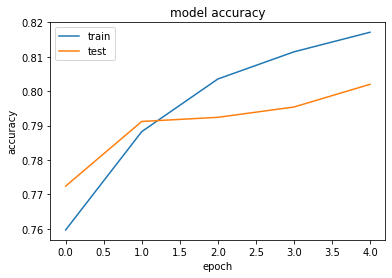

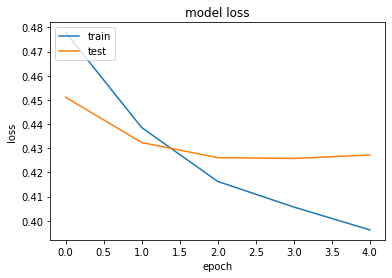

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()